# Identification of the far 3 kpc arm in the Dame 2001 CO map

The data are here:

https://lweb.cfa.harvard.edu/rtdc/CO/download/COGAL_all_interp.fits.gz

The key result is in this paper:

https://ui.adsabs.harvard.edu/abs/2008ApJ...683L.143D/abstract

In [1]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'
pl.rcParams['font.size'] = 16

In [2]:
from dask.diagnostics import ProgressBar
import dask
dask.config.set(scheduler='threads')
pbar = ProgressBar()
pbar.register()

In [3]:
from spectral_cube import SpectralCube
import radio_beam
from astropy import units as u
from astropy import convolution
from astropy.coordinates import SkyCoord

We load up the data and append the 1/8 degree beam (there's no beam in the original data header):

In [4]:
cube = SpectralCube.read("COGAL_all_interp.fits.gz", use_dask=True).with_beam(radio_beam.Beam(1/8*u.deg))

We then create a mask based on the best-fit linear arm model from their Figure 1:

(note that the header incorrectly specifies the velocity unit in m/s instead of km/s)

In [5]:
lmin,lmax = -12,12.5
def v_of_l(ell):
    return (56 + 4.0 * ell)*u.m/u.s
far3kpcarm_mask = [(cube.spectral_axis > v_of_l(l)-13*u.m/u.s) &
                   (cube.spectral_axis < v_of_l(l)+13*u.m/u.s)
                   for l in np.arange(lmax, lmin-0.01, -1/8.)]
far3kpcarm_mask = np.array(far3kpcarm_mask)

Find the corners to cut out of the image to match Fig 3:

In [6]:
xmin,ymin = cube.wcs.celestial.world_to_pixel(SkyCoord(lmin*u.deg,-2.5*u.deg,frame='galactic'))
xmax,ymax = cube.wcs.celestial.world_to_pixel(SkyCoord(lmax*u.deg,2.5*u.deg,frame='galactic'))

Calculate the moment map:

In [7]:
far3kpcarm = cube[:,int(ymin):int(ymax)+1,int(xmax):int(xmin)].with_mask(far3kpcarm_mask.T[:,None,:])
f3m0 = far3kpcarm.moment0()

[########################################] | 100% Completed |  0.2s


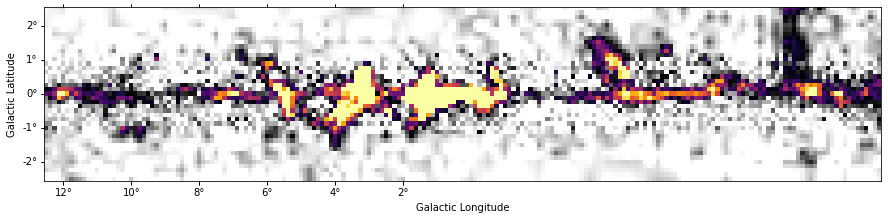

In [8]:
pl.figure(figsize=(15,10))
ax = pl.subplot(projection=far3kpcarm.wcs.celestial)
pl.imshow(f3m0.value, vmax=5, vmin=0, origin='lower', cmap='gray_r', interpolation='none',)
cm = pl.cm.inferno.copy()
cm.set_bad((0,0,0,0))
pl.imshow(np.where(f3m0.value > 5, f3m0.value, np.nan), vmax=25, vmin=5, origin='lower', interpolation='none',
          cmap=cm)
ax.coords[0].set_axislabel('Galactic Longitude')
ax.coords[1].set_axislabel('Galactic Latitude')

Compare to theirs:
    
<img src="https://s3.amazonaws.com/aasie/images/1538-4357/683/2/L143/10_1086_591669_fg3_lr.gif">